In [1]:
import os
import itertools

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import scipy
from scipy import linalg
from scipy.io import loadmat
from sklearn import mixture

from gmm_lbd import GmmManager

%matplotlib inline



In [ ]:
# datas taken from calinon matlab code GMM-GMR-v2 
data1 = loadmat('records/data1.mat')['Data'].transpose( )
print data1.shape
data2_a = loadmat('records/data2_a.mat')['Data'].transpose()
print data2_a.shape
data2_b = loadmat('records/data2_b.mat')['queryData'].transpose()
print data2_b.shape
data3_a = loadmat('records/data3_a.mat')['Data1'].transpose()
print data3_a.shape
data3_b = loadmat('records/data3_b.mat')['Data2'].transpose()
print data3_b.shape

(300, 3)
(300, 4)
(100, 2)
(300, 3)
(300, 3)


/home/theo/Documents/code/gmm-lbd/gmm_lbd/lbd.py:109: RuntimeWarning: divide by zero encountered in double_scalars
  angle = np.arctan(u[1] / u[0])


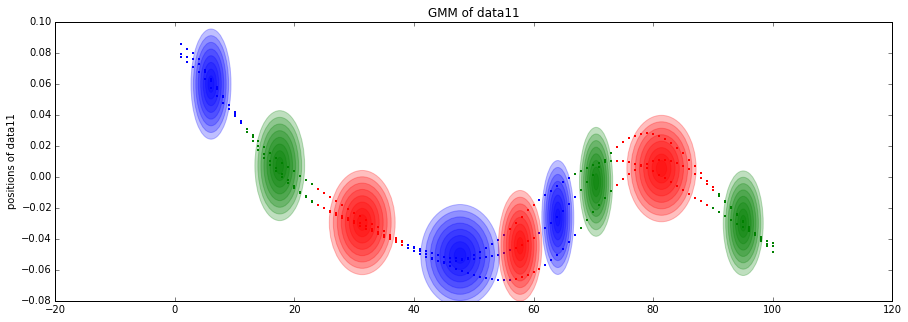

In [ ]:
manager = GmmManager(n_components_range=range(1,10))
manager.add_dataset(data1[:,[0,1]],name='data11')
manager.add_dataset(data1[:,[0,2]],name='data12')

manager.plot_ellipses_and_samples('data11')
manager.plot_ellipses_and_samples('data12')
manager.plot_bics('data11')


In [ ]:
gmm1, gmm2 = manager.gmms['data11'], manager.gmms['data12']
means1, means2 = gmm1.means_, gmm2.means_
covars1, covars2 = gmm1.covars_, gmm2.covars_
cov = np.concatenate((covars1, covars2))
mean = np.concatenate((means1, means2))

manager.plot_ellipses(means=mean, covars=cov,xlim=(-20,120), ylim=(-0.15,0.15))

In [ ]:
manager.add_dataset(data3_a[:,[0,1]],name='data3a')
manager.add_dataset(data3_b[:,[0,1]],name='data3b')
manager.plot_bics('data3a')
manager.plot_ellipses_and_samples('data3a')



In [ ]:
manager.plot_bics('data3b')
manager.plot_ellipses_and_samples('data3b')


In [ ]:
plt.scatter(np.linspace(80,200,800),manager.gmms['data3b'].pdf(data3_b[:,[0,1]]))

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = 100
X = np.ndarray((n_samples, 2))
X[:, 0] = np.linspace(0, 4 * np.pi, n_samples)
X[:, 1] = 1 - 3 * X[:, 0] + random_state.randn(n_samples)
X = data1[:,[0,1]]
mvn = MVN(random_state=0)
mvn.from_samples(X)

X_test = np.linspace(0, 100, 100)
mean, covariance = mvn.predict(np.array([0]), X_test[:, np.newaxis])

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Linear: $p(Y | X) = \mathcal{N}(\mu_{Y|X}, \Sigma_{Y|X})$")
plt.scatter(X[:, 0], X[:, 1])
y = mean.ravel()
s = covariance.ravel()
plt.fill_between(X_test, y - s, y + s, alpha=0.2)
plt.plot(X_test, y, lw=2)

n_samples = 100

gmm = GMM(n_components=4, random_state=42)
gmm.from_samples(X)
Y = gmm.predict(np.array([0]), X_test[:, np.newaxis])

plt.subplot(1, 2, 2)
plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
          "\mathcal{N}_{k, Y|X}$")
plt.scatter(X[:, 0], X[:, 1] ,.8)
plot_error_ellipses(plt.gca(), gmm, colors=["r", "g", "b"])
#plt.plot(X_test, Y.ravel(), lw=2)

plt.show()


In [ ]:

plt.scatter(X_test, Y)
gmm.covariances

In [ ]:
# Tests
import scipy as sp
gmm_sp = manager.gmms['data11']
covars = gmm_sp._get_covars()
means = gmm_sp.means_

In [ ]:
X_test[:, np.newaxis][0]
# Y = gmm_sp.regression(np.array([0]), 25)


In [ ]:
Y = gmm_sp.regression(np.array([0]), X_test[:, np.newaxis])


In [ ]:
plt.scatter(X[:,0],pdf)


In [ ]:

pdf2 = gmm.to_probability_density(X)
plt.scatter(X[:,0],pdf2)


In [ ]:
pdfr = gmm_sp.pdf(X)
plt.scatter(X[:,0],pdfr)


In [ ]:
def invert_indices(n_features, indices):
    inv = np.ones(n_features, dtype=np.bool)
    inv[indices] = False
    inv, = np.where(inv)
    return inv

def conditional_distribution(indices, x,means_, weights_, covars_ ):
    """ Conditional gaussian distribution
        See
        https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions

        Return
        ------
        conditional : GMM
            Conditional GMM distribution p(Y | X=x)
    """
    # Compute conditional gaussian ditsribution
    expected_means = np.empty_like(means_)
    expected_covars = np.empty_like(covars_)
    expected_weights = np.empty_like(weights_)

    # Highly inspired from https://github.com/AlexanderFabisch/gmr
    # Compute expexted_means, expexted_covars, given input X
    for i, (mean, covar, weight) in enumerate(zip(means_, covars_, weights_)):
        i1, i2 = invert_indices(mean.shape[0], indices), indices
        cov_12 = covar[np.ix_(i1, i2)]
        cov_11 = covar[np.ix_(i1, i1)]
        cov_22 = covar[np.ix_(i2, i2)]
        prec_22 = linalg.pinvh(cov_22)
        regression_coeffs = cov_12.dot(prec_22)
        if x.ndim == 1:
            x = x[:, np.newaxis]
        expected_means[i] = mean[i1] + regression_coeffs.dot((x - mean[i2]).T).T
        expected_covars[i] = cov_11 - regression_coeffs.dot(cov_12.T)
        # expected_weights[i] = weight * gauss_pdf(x, mean=mean[indices], cov=covar[indices])
        try:
            expected_weights[i] = weight * mvn.pdf(x, mean=mean[indices], cov=covar[indices])
        except:
            print i, x, expected_means[i], expected_covars[i]
        
    expected_weights /= expected_weights.sum()           
    return expected_means, expected_covars, expected_weights

def regression(indices, X, means_, weights_, covars_):
        """Predict expected means and expected covariances

        Parameters
        ----------
        indices : array, shape (n_features_1,)
            Indices of dimensions that we want to condition.

        X : array, shape (n_samples, n_features_1)
            Values of the features that we know.

        Returns
        -------
        Y : array, shape (n_samples, n_features_2)
            Predicted means of missing values.
        """

        n_samples, n_features_1 = X.shape
        n_features_2 = means_.shape[1] - n_features_1
        Y = np.empty((n_samples, n_features_2))
        for n in range(n_samples):
            print 'n', n

            means, covars, weights = conditional_distribution(indices, X[n], means_, weights_, covars_)
            print 'mean'
            Y[n] = weights.dot(means)
        return Y



In [ ]:
predict_gmm = regression(np.array([0]), X_test[:, np.newaxis], gmm.means, gmm.priors, gmm.covariances)


In [ ]:
predict_gmm = regression(np.array([0]), X_test[:, np.newaxis], gmm_sp.means_, gmm_sp.weights_, gmm_sp.covars_)


In [ ]:
predict_gmm = regression(np.array([0]), X_test[:, np.newaxis], gmm.means, gmm.priors, gmm.covariances)
means, covars, weights = conditional_distribution(indices, X[n], means_, weights_, covars_)
